In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import time
import umap.umap_ as umap
from sklearn.manifold import TSNE
import numba
import random
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split
import trimap
import pacmap
import numpy as np


def plot_2d_scatter(X, Y, labels):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)

    labels = labels.to_numpy().flatten()
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i) / max(unique)) for i in unique]

    for i, u in enumerate(unique):
        xi = [X[j] for j in range(len(X)) if labels[j] == u]
        yi = [Y[j] for j in range(len(X)) if labels[j] == u]
        plt.scatter(xi, yi, color=colors[i], label=str(u), s=2)

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

markers = ["x", "o", "s", "*", "^", ".", "X"]
colors = ["red", "blue", "green", "brown", "orange", "cyan", "grey", "purple"]


@numba.jit(nopython=True)
def knngain(d_hd, d_ld, labels):
    # Number of data points
    N = d_hd.shape[0]
    N_1 = N - 1
    k_hd = np.zeros(shape=N_1, dtype=np.int64)
    k_ld = np.zeros(shape=N_1, dtype=np.int64)
    # For each data point
    for i in range(N):
        c_i = labels[i]
        di_hd = d_hd[i, :].argsort(kind="mergesort")
        di_ld = d_ld[i, :].argsort(kind="mergesort")
        # Making sure that i is first in di_hd and di_ld
        for arr in [di_hd, di_ld]:
            for idj, j in enumerate(arr):
                if j == i:
                    idi = idj
                    break
            if idi != 0:
                arr[idi] = arr[0]
            arr = arr[1:]
        for k in range(N_1):
            if c_i == labels[di_hd[k]]:
                k_hd[k] += 1
            if c_i == labels[di_ld[k]]:
                k_ld[k] += 1
    # Computing the KNN gain
    gn = (k_ld.cumsum() - k_hd.cumsum()).astype(np.float64) / (
        (1.0 + np.arange(N_1)) * N
    )
    # Returning the KNN gain and its AUC
    return gn, eval_auc(gn)


@numba.jit(nopython=True)
def eval_auc(arr):
    i_all_k = 1.0 / (np.arange(arr.size) + 1.0)
    return np.float64(arr.dot(i_all_k)) / (i_all_k.sum())


@numba.jit(nopython=True)
def eval_rnx(Q):
    N_1 = Q.shape[0]
    N = N_1 + 1
    # Computing Q_NX
    qnxk = np.empty(shape=N_1, dtype=np.float64)
    acc_q = 0.0
    for K in range(N_1):
        acc_q += Q[K, K] + np.sum(Q[K, :K]) + np.sum(Q[:K, K])
        qnxk[K] = acc_q / ((K + 1) * N)
    # Computing R_NX
    arr_K = np.arange(N_1)[1:].astype(np.float64)
    rnxk = (N_1 * qnxk[: N_1 - 1] - arr_K) / (N_1 - arr_K)
    # Returning
    return rnxk


def eval_dr_quality(d_hd, d_ld):
    # Computing the co-ranking matrix of the embedding, and the R_{NX}(K) curve.
    rnxk = eval_rnx(Q=coranking(d_hd=d_hd, d_ld=d_ld))
    # Computing the AUC, and returning.
    return rnxk, eval_auc(rnxk)


def coranking(d_hd, d_ld):
    # Computing the permutations to sort the rows of the distance matrices in HDS and LDS.
    perm_hd = d_hd.argsort(axis=-1, kind="mergesort")
    perm_ld = d_ld.argsort(axis=-1, kind="mergesort")

    N = d_hd.shape[0]
    i = np.arange(N, dtype=np.int64)
    # Computing the ranks in the LDS
    R = np.empty(shape=(N, N), dtype=np.int64)
    for j in range(N):
        R[perm_ld[j, i], j] = i
    # Computing the co-ranking matrix
    Q = np.zeros(shape=(N, N), dtype=np.int64)
    for j in range(N):
        Q[i, R[perm_hd[j, i], j]] += 1
    # Returning
    return Q[1:, 1:]


def viz_qa(
    Ly,
    ymin=None,
    ymax=None,
    Lmarkers=None,
    Lcols=None,
    Lleg=None,
    Lls=None,
    Lmedw=None,
    Lsdots=None,
    lw=2,
    markevery=0.1,
    tit="",
    folder_name="",
    xlabel="",
    ylabel="",
    alpha_plot=0.9,
    alpha_leg=0.8,
    stit=25,
    sax=20,
    sleg=15,
    zleg=1,
    loc_leg="best",
    ncol_leg=1,
    lMticks=10,
    lmticks=5,
    wMticks=2,
    wmticks=1,
    nyMticks=11,
    mymticks=4,
    grid=True,
    grid_ls="solid",
    grid_col="lightgrey",
    grid_alpha=0.7,
    xlog=True,
):
    # Number of curves
    nc = len(Ly)
    # Checking the parameters
    if ymin is None:
        ymin = np.min(np.asarray([arr.min() for arr in Ly]))
    if ymax is None:
        ymax = np.max(np.asarray([arr.max() for arr in Ly]))
    if Lmarkers is None:
        Lmarkers = ["x"] * nc
    if Lcols is None:
        Lcols = ["blue"] * nc
    if Lleg is None:
        Lleg = [None] * nc
        add_leg = False
    else:
        add_leg = True
    if Lls is None:
        Lls = ["solid"] * nc
    if Lmedw is None:
        Lmedw = [float(lw) / 2.0] * nc
    if Lsdots is None:
        Lsdots = [12] * nc

    # Setting the limits of the y-axis
    y_lim = [ymin, ymax]

    # Defining the ticks on the y-axis
    yMticks = np.linspace(
        start=ymin, stop=ymax, num=nyMticks, endpoint=True, retstep=False
    )
    ymticks = np.linspace(
        start=ymin,
        stop=ymax,
        num=1 + mymticks * (nyMticks - 1),
        endpoint=True,
        retstep=False,
    )
    yMticksLab = [int(round(v * 100.0)) / 100.0 for v in yMticks]

    # Initial values for xmin and xmax
    xmin, xmax = 1, -np.inf

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    if xlog:
        fplot = ax.semilogx
    else:
        fplot = ax.plot

    # Plotting the data
    for id, y in enumerate(Ly):
        x = np.arange(start=1, step=1, stop=y.size + 0.5, dtype=np.int64)
        xmax = max(xmax, x[-1])
        fplot(
            x,
            y,
            label=Lleg[id],
            alpha=alpha_plot,
            color=Lcols[id],
            linestyle=Lls[id],
            lw=lw,
            marker=Lmarkers[id],
            markeredgecolor=Lcols[id],
            markeredgewidth=Lmedw[id],
            markersize=Lsdots[id],
            dash_capstyle="round",
            solid_capstyle="round",
            dash_joinstyle="round",
            solid_joinstyle="round",
            markerfacecolor=Lcols[id],
            markevery=markevery,
        )

    # Setting the limits of the axes
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(y_lim)

    # Setting the major and minor ticks on the y-axis
    ax.set_yticks(yMticks, minor=False)
    ax.set_yticks(ymticks, minor=True)
    ax.set_yticklabels(yMticksLab, minor=False, fontsize=sax)

    # Defining the legend
    if add_leg:
        leg = ax.legend(
            loc=loc_leg,
            fontsize=sleg,
            markerfirst=True,
            fancybox=True,
            framealpha=alpha_leg,
            ncol=ncol_leg,
        )
        if zleg is not None:
            leg.set_zorder(zleg)

    # Setting the size of the ticks labels on the x axis
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(sax)

    # Setting ticks length and width
    ax.tick_params(axis="both", length=lMticks, width=wMticks, which="major")
    ax.tick_params(axis="both", length=lmticks, width=wmticks, which="minor")

    # Setting the positions of the labels
    ax.xaxis.set_tick_params(labelright=False, labelleft=True)
    ax.yaxis.set_tick_params(labelright=False, labelleft=True)

    # Adding the grids
    if grid:
        ax.xaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
        ax.yaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
    ax.set_axisbelow(True)

    ax.set_title(tit, fontsize=stit)
    ax.set_xlabel(xlabel, fontsize=sax)
    ax.set_ylabel(ylabel, fontsize=sax)
    # plt.tight_layout()

    # Showing the figure
    fig.savefig(
        "{}.png".format(
            tit
        ),
        dpi=fig.dpi,
    )


class LocalMetric:
    def __init__(self):
        self.L_rnx = []
        self.L_kg = []
        self.Lleg_rnx = []
        self.Lleg_kg = []
        self.Lls = []
        self.number_of_methods = 0

    def calculate_knn_gain_and_dr_quality(
        self,
        X_lds: np.ndarray,
        X_hds: np.ndarray,
        labels: np.ndarray,
        method_name: str,
    ):

        (
            X_hds_train,
            X_hds_test,
            X_lds_train,
            X_lds_test,
            labels_train,
            labels_test,
        ) = train_test_split(X_hds, X_lds, labels, test_size=0.15)

        print("Calculating d_hd")
        d_hd = squareform(X=pdist(X=X_hds_test, metric="euclidean"), force="tomatrix")

        print(method_name)
        d_ld = squareform(X=pdist(X=X_lds_test, metric="euclidean"), force="tomatrix")
        rnxk, auc_rnx = eval_dr_quality(d_hd=d_hd, d_ld=d_ld)
        kg, auc_kg = knngain(d_hd=d_hd, d_ld=d_ld, labels=labels_test)

        self.L_rnx.append(rnxk)
        self.L_kg.append(kg)
        self.Lleg_rnx.append(
            "{} {}".format(int(round(auc_rnx * 1000)) / 1000.0, method_name)
        )
        self.Lleg_kg.append(
            "{} {}".format(int(round(auc_kg * 1000)) / 1000.0, method_name)
        )
        self.Lls.append("solid")
        self.number_of_methods = self.number_of_methods + 1

    def visualize(self):
        Lmarkers = random.sample(markers, self.number_of_methods)
        Lcols = random.sample(colors, self.number_of_methods)
        Lmedw = [1.0] * self.number_of_methods
        Lsdots = [12] * self.number_of_methods

        viz_qa(
            Ly=self.L_rnx,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_rnx,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="DR quality",
            xlabel="Neighborhood size $K$",
            ylabel="$R_{NX}(K)$",
        )

        viz_qa(
            Ly=self.L_kg,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_kg,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="KNN gain",
            xlabel="Neighborhood size $K$",
            ylabel="$G_{NN}(K)$",
        )

        print("Finished.")

/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
dataset = pd.read_csv('/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv', header=None)
labels = pd.read_csv('/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_labels.csv', header=None)

# # Uncomment if datasets already calculated and you only want to change metrics/visualizations
# ivhd_results = []
# largevis_results = []
#
# tsne_p40_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("tsne_p40"), delimiter=",")
# tsne_p80_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("tsne_p80"), delimiter=",")
# tsne_p120_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("tsne_p120"), delimiter=",")
#
# umap_nn15_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("umap_nn_15"), delimiter=",")
# umap_nn30_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("umap_nn_30"), delimiter=",")
# umap_nn50_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("umap_nn_50"), delimiter=",")
#
# trimap_ni10_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("trimap_ni_10"), delimiter=",")
# trimap_ni20_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("trimap_ni_20"), delimiter=",")
# trimap_ni40_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("trimap_ni_40"), delimiter=",")
#
# pacmap_nn10_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("pacmap_nn_10"), delimiter=",")
# pacmap_nn15_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("pacmap_nn_15"), delimiter=",")
# pacmap_nn20_transformed = np.loadtxt("../embeddings/reuters/{}.txt".format("pacmap_nn_20"), delimiter=",")
#
# ivhd_2nn = np.loadtxt("../embeddings/reuters/{}.txt".format("ivhd_cosine_2nn"), delimiter=",")
# ivhd_3nn = np.loadtxt("../embeddings/reuters/{}.txt".format("ivhd_cosine_3nn"), delimiter=",")
# ivhd_5nn = np.loadtxt("../embeddings/reuters/{}.txt".format("ivhd_cosine_5nn"), delimiter=",")
#
# ivhd_results.append(ivhd_2nn)
# ivhd_results.append(ivhd_3nn)
# ivhd_results.append(ivhd_5nn)
#
# largevis_3nn = np.loadtxt("../embeddings/reuters/{}.txt".format("largevis_3nn"), delimiter=",")
# largevis_10nn = np.loadtxt("../embeddings/reuters/{}.txt".format("largevis_10nn"), delimiter=",")
# largevis_30nn = np.loadtxt("../embeddings/reuters/{}.txt".format("largevis_30nn"), delimiter=",")
#
# largevis_results.append(largevis_3nn)
# largevis_results.append(largevis_10nn)
# largevis_results.append(largevis_30nn)
#
# ivhd_names = [
#     "IVHD cosine 2nn",
#     "IVHD cosine 3nn",
#     "IVHD cosine 5nn",
# ]
#
# largevis_names = [
#     "LargeVis 3nn",
#     "LargeVis 10nn",
#     "LargeVis 30nn",
# ]

### t-SNE

In [ ]:
tsne_p40 = TSNE(perplexity=40)
tsne_p80 = TSNE(perplexity=80)
tsne_p120 = TSNE(perplexity=120)

tsne_p40_start = time.time()
tsne_p40_transformed = tsne_p40.fit_transform(dataset)
tsne_p40_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("tsne_p40"), tsne_p40_transformed, delimiter=",", fmt='%.6e')

tsne_p80_start = time.time()
tsne_p80_transformed = tsne_p80.fit_transform(dataset)
tsne_p80_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("tsne_p80"), tsne_p80_transformed, delimiter=",", fmt='%.6e')

tsne_p120_start = time.time()
tsne_p120_transformed = tsne_p120.fit_transform(dataset)
tsne_p120_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("tsne_p120"), tsne_p120_transformed, delimiter=",", fmt='%.6e')

/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bartoszminch/miniconda3/envs/viskit/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE w

In [ ]:
print("t-SNE (perp=40): {} [s]".format(tsne_p40_end - tsne_p40_start))
plot_2d_scatter(tsne_p40_transformed[:,0], tsne_p40_transformed[:,1], labels)

print("t-SNE (perp=80): {} [s]".format(tsne_p80_end - tsne_p80_start))
plot_2d_scatter(tsne_p80_transformed[:,0], tsne_p80_transformed[:,1], labels)

print("t-SNE (perp=120): {} [s]".format(tsne_p120_end - tsne_p120_start))
plot_2d_scatter(tsne_p120_transformed[:,0], tsne_p120_transformed[:,1], labels)

### UMAP

In [3]:
umap_nn15 = umap.UMAP(n_neighbors=15)
umap_nn30 = umap.UMAP(n_neighbors=30)
umap_nn50 = umap.UMAP(n_neighbors=50)

umap_nn15_start = time.time()
umap_nn15_transformed = umap_nn15.fit_transform(dataset)
umap_nn15_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("umap_nn_15"), umap_nn15_transformed, delimiter=",", fmt='%.6e')

umap_nn30_start = time.time()
umap_nn30_transformed = umap_nn30.fit_transform(dataset)
umap_nn30_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("umap_nn_30"), umap_nn30_transformed, delimiter=",", fmt='%.6e')

umap_nn50_start = time.time()
umap_nn50_transformed = umap_nn50.fit_transform(dataset)
umap_nn50_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("umap_nn_50"), umap_nn50_transformed, delimiter=",", fmt='%.6e')

UMAP (nn=15): 12269.18841791153 [s]


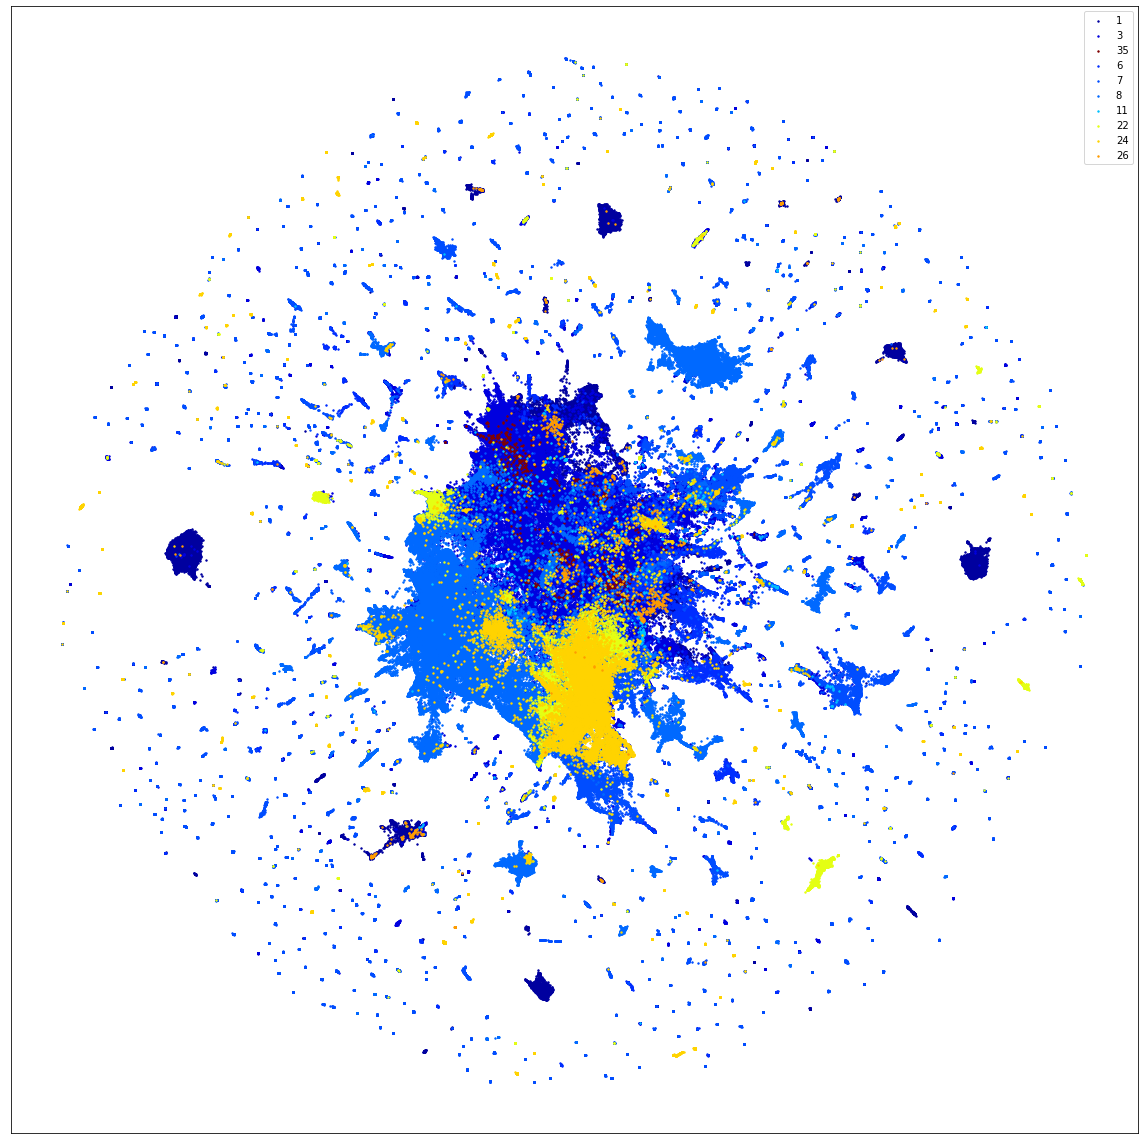

UMAP (nn=30): 23258.880496025085 [s]


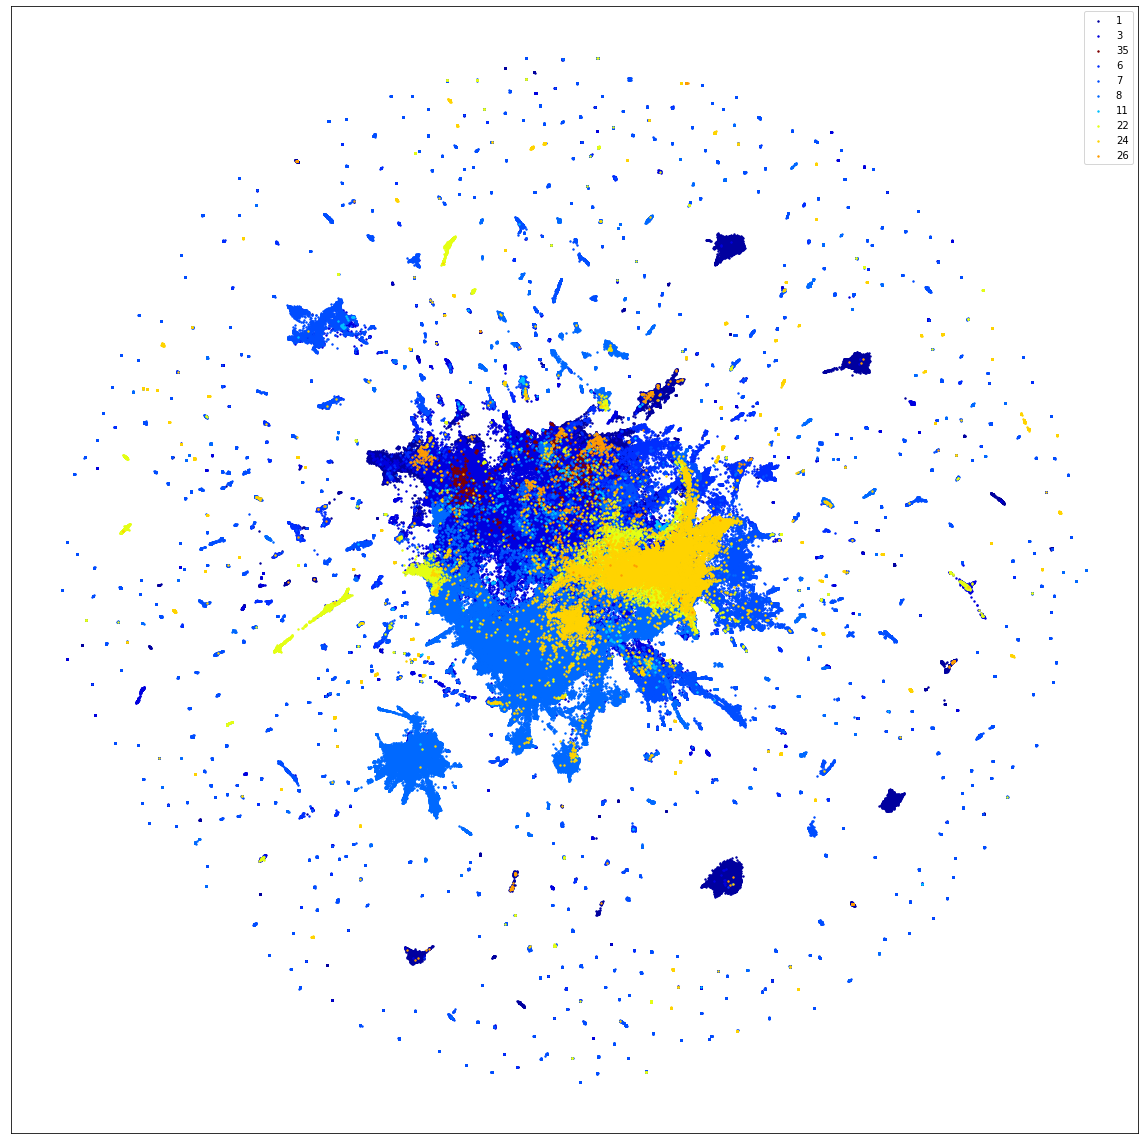

UMAP (nn=50): 13389.119104146957 [s]


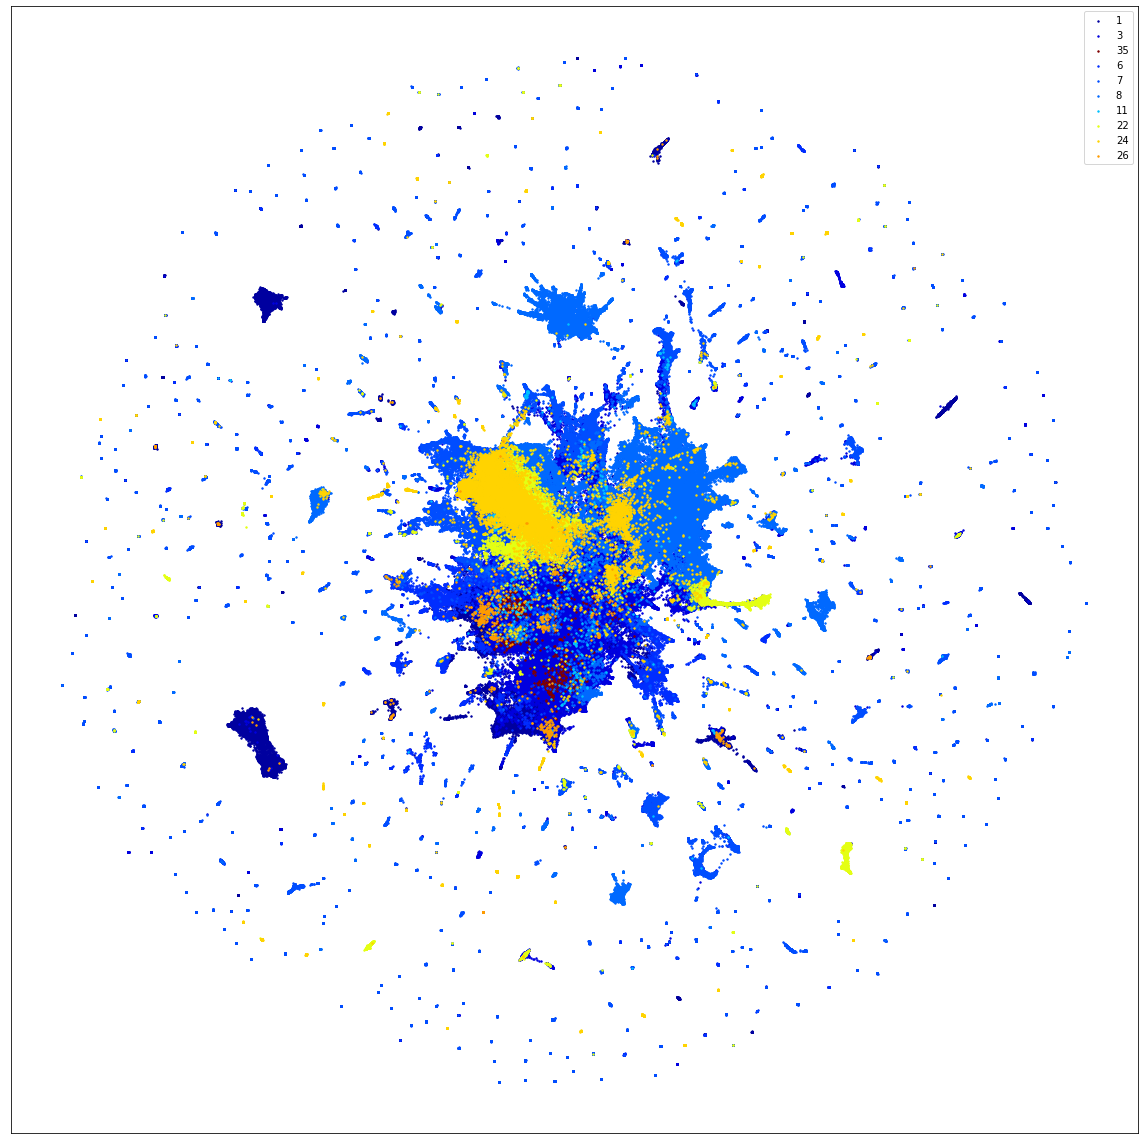

In [4]:
print("UMAP (nn=15): {} [s]".format(umap_nn15_end - umap_nn15_start))
plot_2d_scatter(umap_nn15_transformed[:,0], umap_nn15_transformed[:,1], labels)

print("UMAP (nn=30): {} [s]".format(umap_nn30_end - umap_nn30_start))
plot_2d_scatter(umap_nn30_transformed[:,0], umap_nn30_transformed[:,1], labels)

print("UMAP (nn=50): {} [s]".format(umap_nn50_end - umap_nn50_start))
plot_2d_scatter(umap_nn50_transformed[:,0], umap_nn50_transformed[:,1], labels)

### TriMap

In [5]:
trimap_ni10 = trimap.TRIMAP(n_inliers=12, n_outliers=4, n_random=3)
trimap_ni20 = trimap.TRIMAP(n_inliers=20, n_outliers=5, n_random=5)
trimap_ni40 = trimap.TRIMAP(n_inliers=40, n_outliers=5, n_random=5)

trimap_ni10_start = time.time()
trimap_ni10_transformed = trimap_ni10.fit_transform(dataset.to_numpy())
trimap_ni10_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("trimap_ni_10"), trimap_ni10_transformed, delimiter=",", fmt='%.6e')

trimap_ni20_start = time.time()
trimap_ni20_transformed = trimap_ni20.fit_transform(dataset.to_numpy())
trimap_ni20_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("trimap_ni_20"), trimap_ni20_transformed, delimiter=",", fmt='%.6e')

trimap_ni40_start = time.time()
trimap_ni40_transformed = trimap_ni40.fit_transform(dataset.to_numpy())
trimap_ni40_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("trimap_ni_40"), trimap_ni40_transformed, delimiter=",", fmt='%.6e')

TriMap (ni=10): 1498.9632749557495 [s]


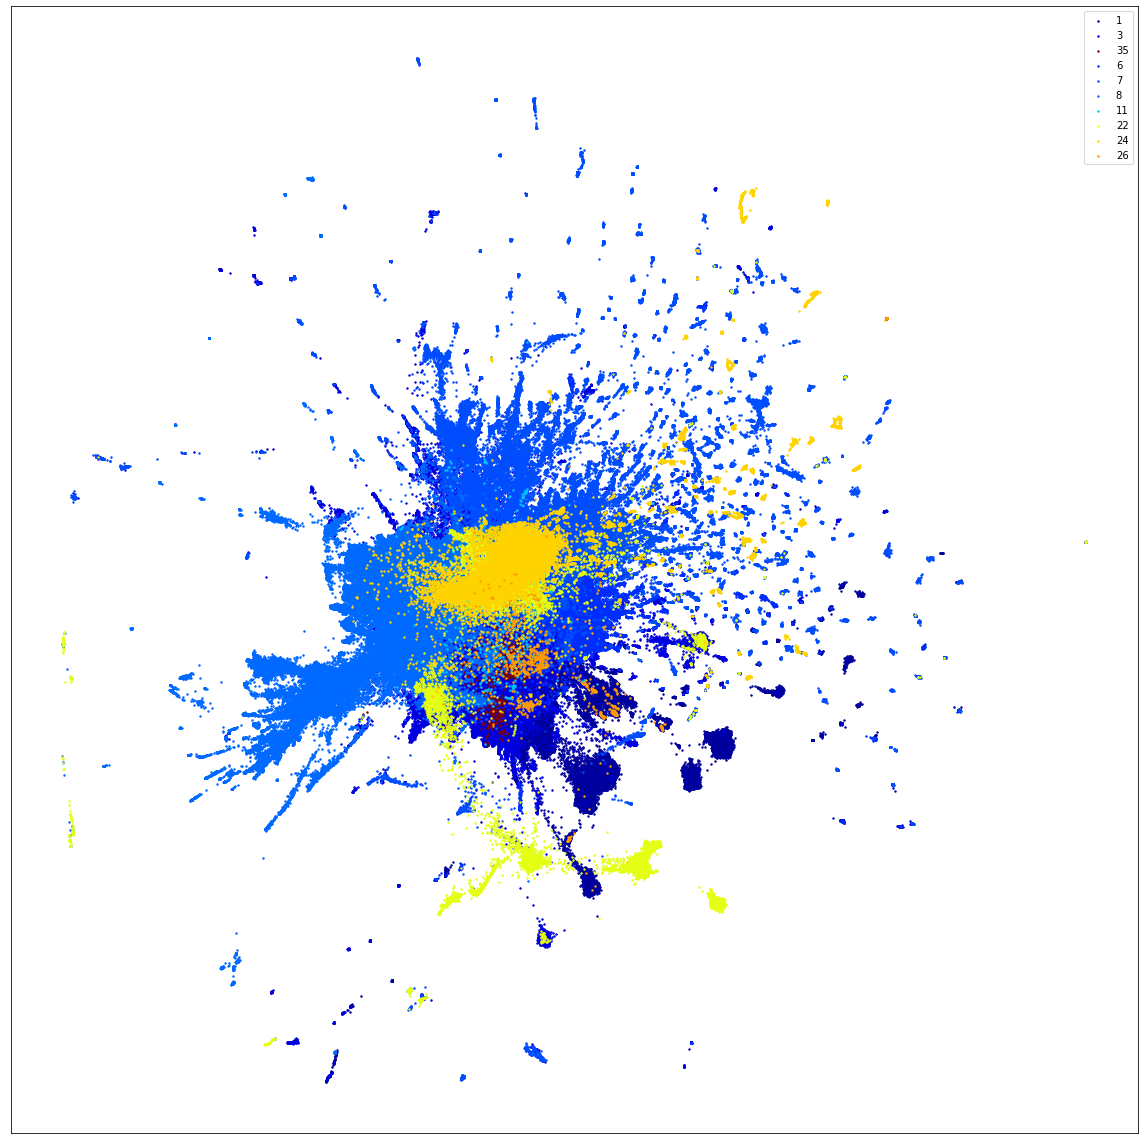

TriMap (ni=20): 2796.452679157257 [s]


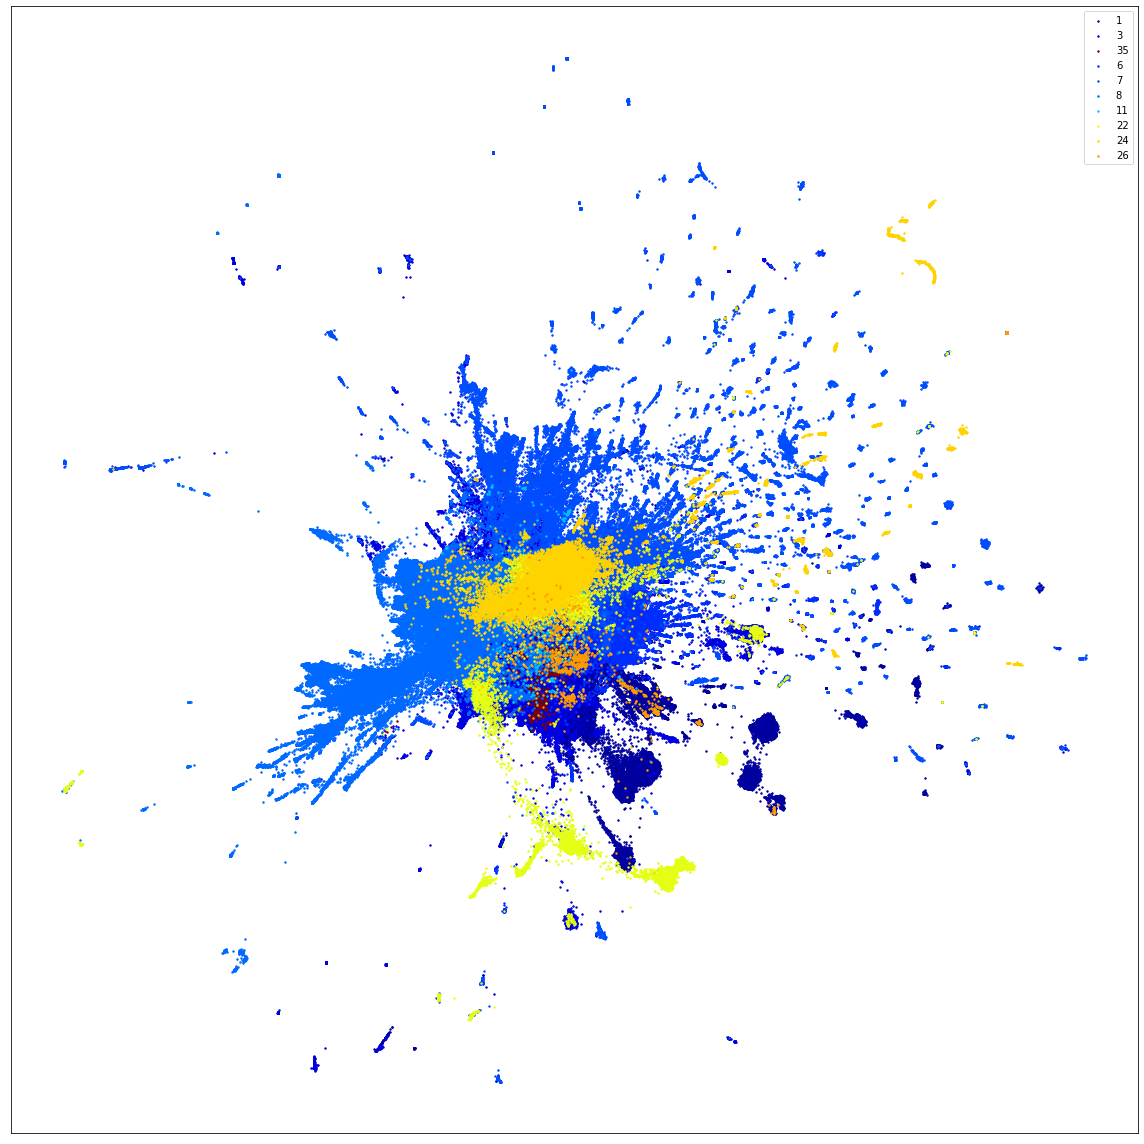

TriMap (ni=40): 43883.74583506584 [s]


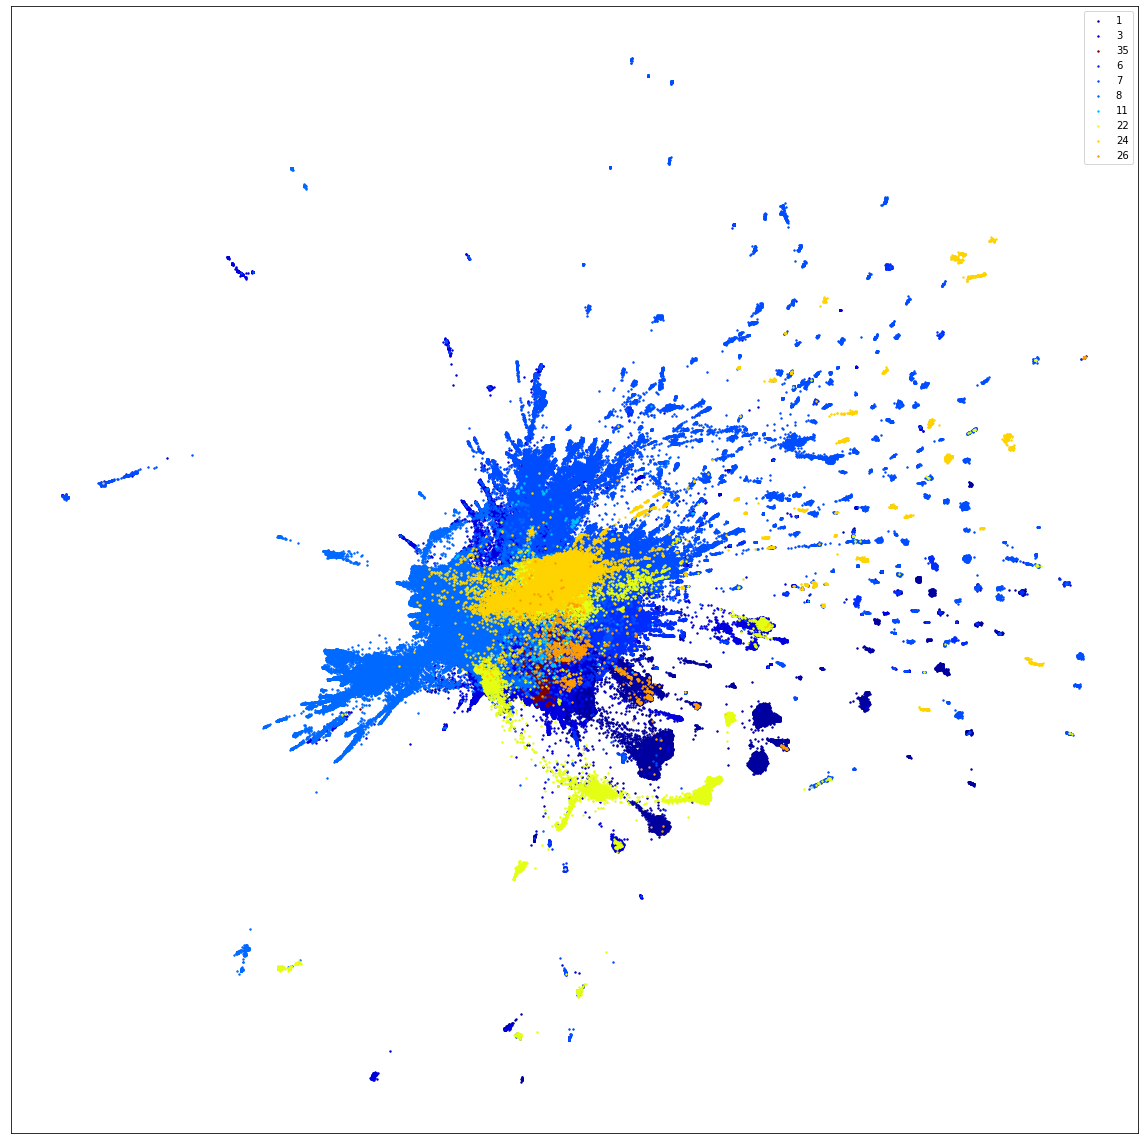

In [6]:
print("TriMap (ni=10): {} [s]".format(trimap_ni10_end - trimap_ni10_start))
plot_2d_scatter(trimap_ni10_transformed[:,0], trimap_ni10_transformed[:,1], labels)

print("TriMap (ni=20): {} [s]".format(trimap_ni20_end - trimap_ni20_start))
plot_2d_scatter(trimap_ni20_transformed[:,0], trimap_ni20_transformed[:,1], labels)

print("TriMap (ni=40): {} [s]".format(trimap_ni40_end - trimap_ni40_start))
plot_2d_scatter(trimap_ni40_transformed[:,0], trimap_ni40_transformed[:,1], labels)

### PaCMAP

In [7]:
pacmap_nn10 = pacmap.PaCMAP(n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
pacmap_nn15 = pacmap.PaCMAP(n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0)
pacmap_nn20 = pacmap.PaCMAP(n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0)

pacmap_nn10_start = time.time()
pacmap_nn10_transformed = pacmap_nn10.fit_transform(dataset.to_numpy(), init="pca")
pacmap_nn10_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("pacmap_nn_10"), pacmap_nn10_transformed, delimiter=",", fmt='%.6e')

pacmap_nn15_start = time.time()
pacmap_nn15_transformed = pacmap_nn15.fit_transform(dataset.to_numpy(), init="pca")
pacmap_nn15_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("pacmap_nn_15"), pacmap_nn15_transformed, delimiter=",", fmt='%.6e')

pacmap_nn20_start = time.time()
pacmap_nn20_transformed = pacmap_nn20.fit_transform(dataset.to_numpy(), init="pca")
pacmap_nn20_end = time.time()
np.savetxt("../embeddings/reuters/{}.txt".format("pacmap_nn_20"), pacmap_nn20_transformed, delimiter=",", fmt='%.6e')

PaCMAP (nn=10): 851.4631240367889 [s]


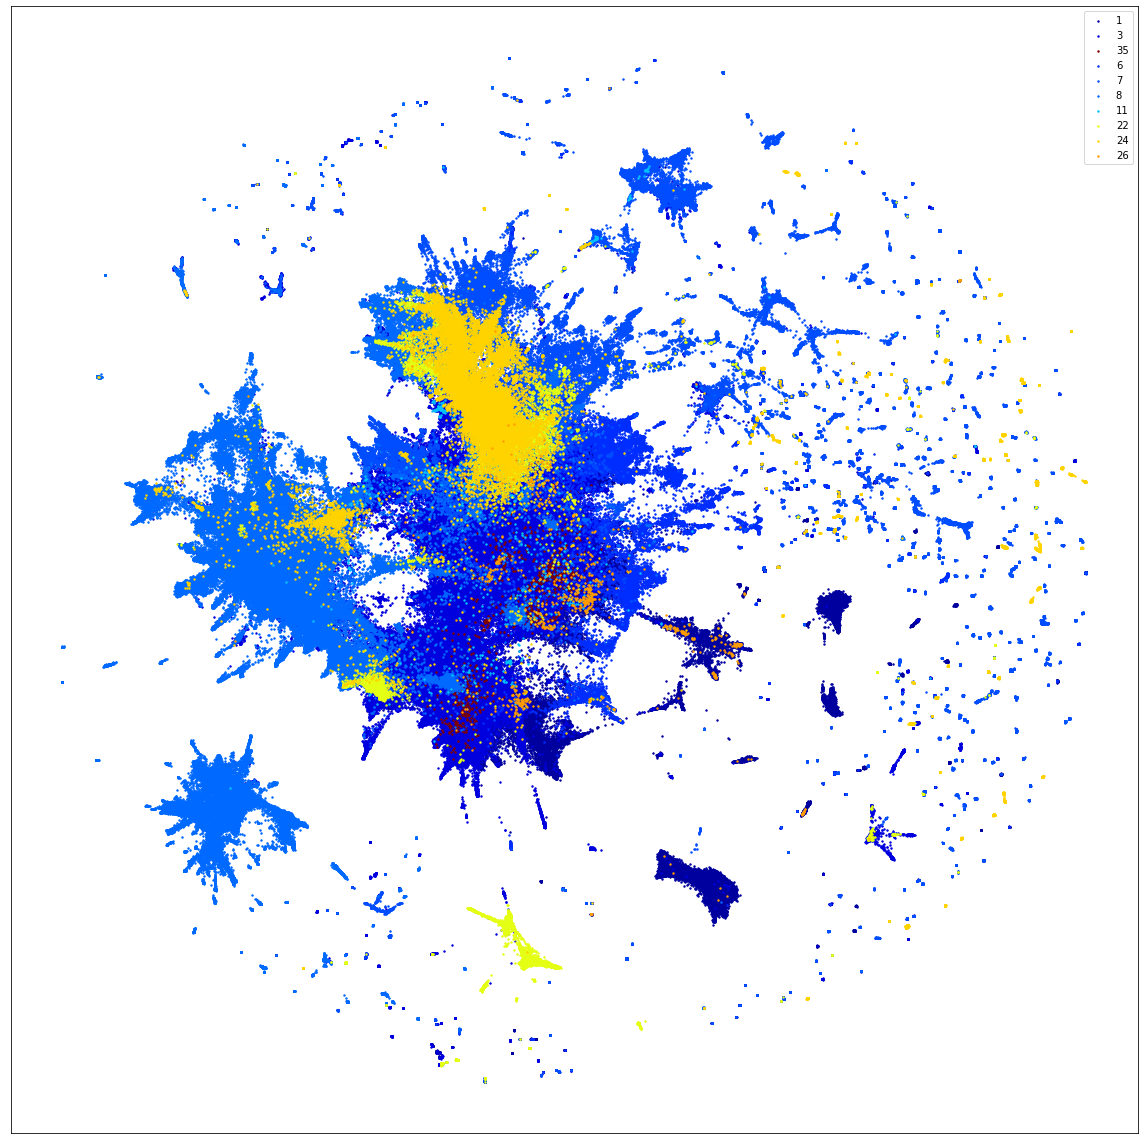

PaCMAP (nn=15): 1149.2515878677368 [s]


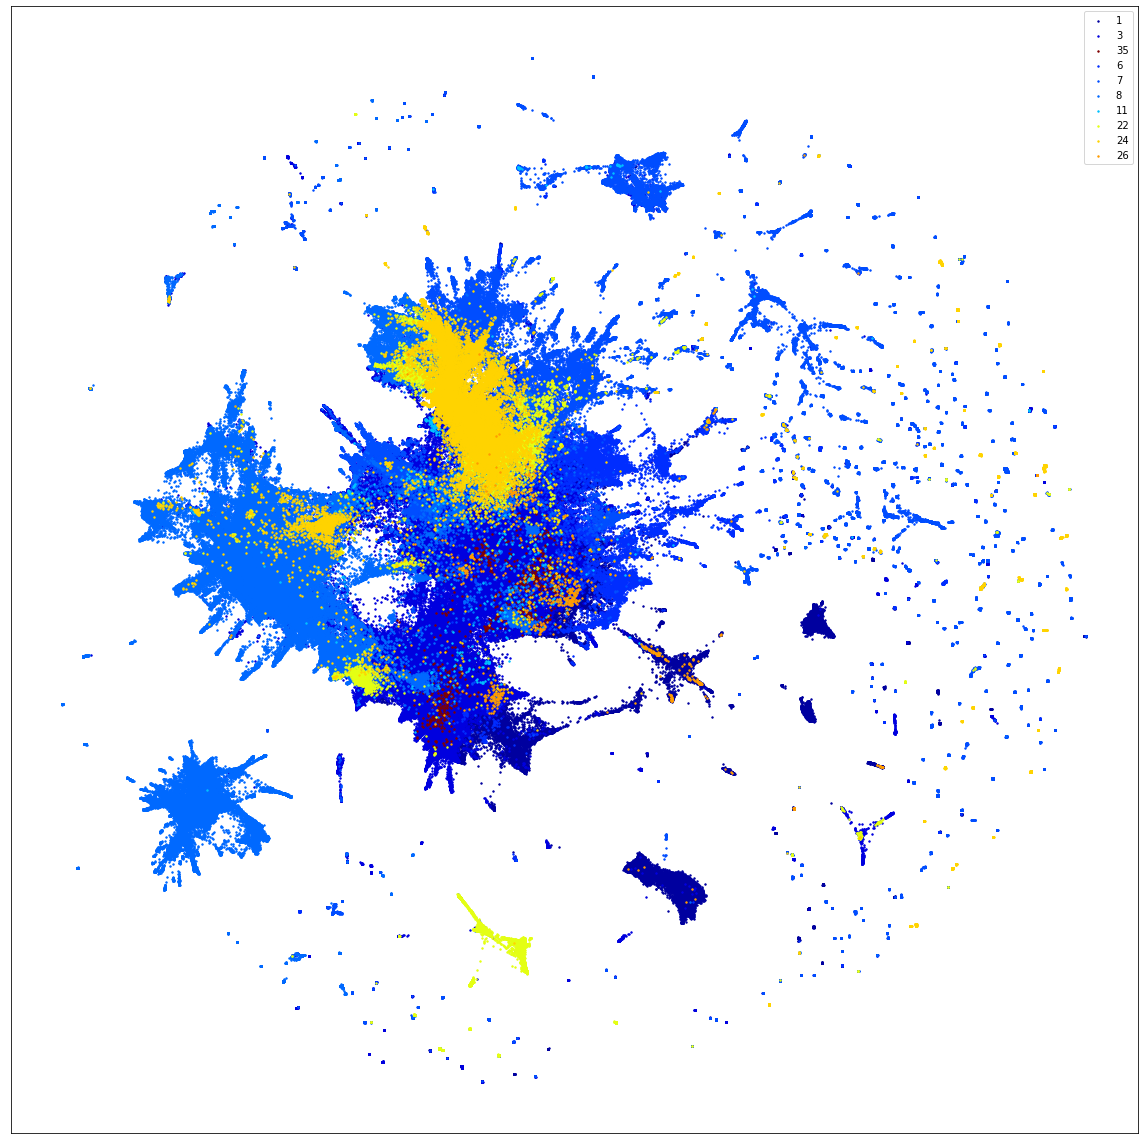

PaCMAP (nn=20): 1632.3550090789795 [s]


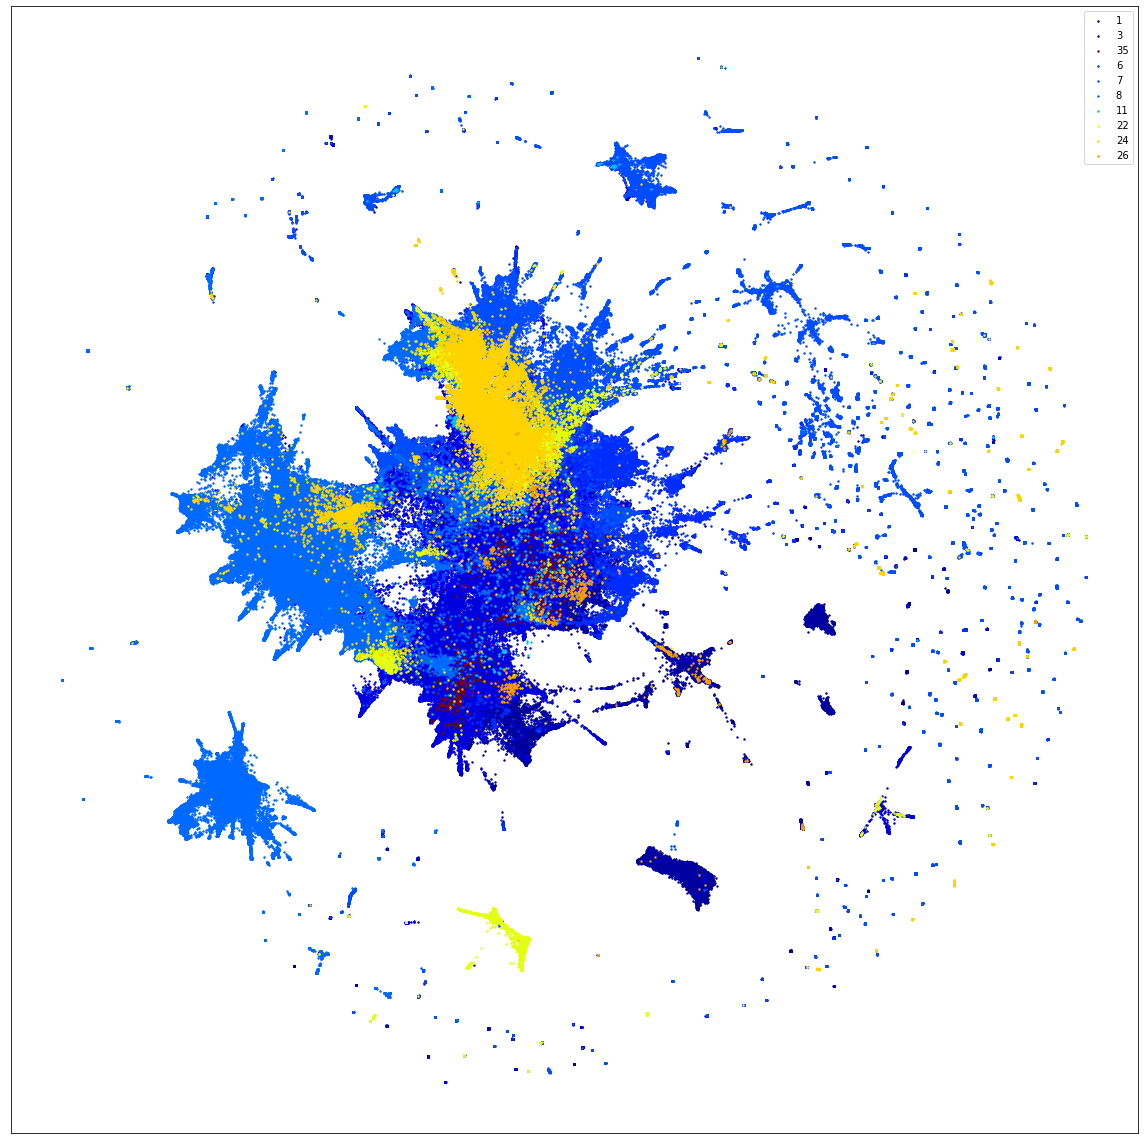

In [8]:
print("PaCMAP (nn=10): {0} [s]".format(pacmap_nn10_end - pacmap_nn10_start))
plot_2d_scatter(pacmap_nn10_transformed[:,0], pacmap_nn10_transformed[:,1], labels)

print("PaCMAP (nn=15): {0} [s]".format(pacmap_nn15_end - pacmap_nn15_start))
plot_2d_scatter(pacmap_nn15_transformed[:,0], pacmap_nn15_transformed[:,1], labels)

print("PaCMAP (nn=20): {0} [s]".format(pacmap_nn20_end - pacmap_nn20_start))
plot_2d_scatter(pacmap_nn20_transformed[:,0], pacmap_nn20_transformed[:,1], labels)

### IVHD

In [9]:
ivhd_const_args = {
    'dir': "../viskit_offline_big_datasets",
    'dataset_csv': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv",
    'labels_csv': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_labels.csv",
    'output': "../data/reuters.txt",
    'iter': 4500,
    'bd': 1, # binaryDistances
    'rns': 0, # reverseNeighborsSteps
    'rnc': 0, # reverseNeighborsCount
    'l1s': 0, # l1Steps
    'optimizer': "force-directed"
}

ivhd_args = [
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 2, 'rn': 1},
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 3, 'rn': 1},
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 5, 'rn': 1},
    # {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_cosine.bin", 'nn': 2, 'rn': 1},
    # {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_cosine.bin", 'nn': 3, 'rn': 1},
    # {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_cosine.bin", 'nn': 5, 'rn': 1},
]

ivhd_names = [
    "IVHD euclidean 2nn",
    "IVHD euclidean 3nn",
    "IVHD euclidean 5nn",
    # "IVHD cosine 2nn",
    # "IVHD cosine 3nn",
    # "IVHD cosine 5nn",
]

def get_ivhd_result(output_file) -> pd.DataFrame:
    df_ivhd = pd.read_csv(output_file, header=None)
    x_ivhd = df_ivhd.loc[:, '0':'1'].values
    return x_ivhd

import os

ivhd_results = []
ivhd_timings = []

i = 0
for args in ivhd_args:
    gp_arg = args['gp']
    nn_arg = args['nn']
    rn_arg = args['rn']

    command = '{dir} "{data_csv}" "{labels_csv}" "{gp}" {output} {iter} {nn} {rn} {bd} {rns} {rnc} {l1s} "{optimizer}"'.format(
        dir = ivhd_const_args['dir'],
        data_csv = ivhd_const_args['dataset_csv'],
        labels_csv = ivhd_const_args['labels_csv'],
        gp = gp_arg,
        output = ivhd_const_args['output'],
        iter = ivhd_const_args['iter'],
        nn = nn_arg,
        rn = rn_arg,
        bd = ivhd_const_args['bd'],
        rns = ivhd_const_args['rns'],
        rnc = ivhd_const_args['rnc'],
        l1s = ivhd_const_args['l1s'],
        optimizer = ivhd_const_args['optimizer'],
    )

    ivhd_time_start = time.time()
    os.system(command)
    ivhd_time_end = time.time()
    ivhd_timings.append(ivhd_time_end-ivhd_time_start)

    res = get_ivhd_result(ivhd_const_args['output'])
    np.savetxt("../embeddings/reuters/{}.txt".format(ivhd_names[i].lower().replace(" ", "_")), res, delimiter=",", fmt='%.6e')
    ivhd_results.append(res)
    i += 1

[Info] [CSV Parser] Loading dataset from file: /Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv
[Info] [CSV Parser] Loading labels from file: /Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_labels.csv
[Info] [CSV Parser] Labels file passed.
[Info] [CSV Parser] Dataset size: 795645
[Info] [CSV Parser] Dataset dimensionality: 30
[Info] [CSV Parser] Number of classes in dataset: 10
[Info] [CSV Parser] Finished.
[Info] [Graph] Loading graph from cache...
[Info] [Graph] Using binary distances...
[Info] [Graph] Finished.
[Info] [kNN Generator] Determining random neighbors...
[Info] [kNN Generator] Finished.
[Info] [kNN Generator] Neighbors in graph: 2386935
[Info] [CSV Parser] Loading dataset from file: /Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv
[Info] [CSV Parser] Loading labels from file: /Users/bartoszminch/Documents/Repositories/d

IVHD euclidean 2nn: 1742.8451790809631 [s]


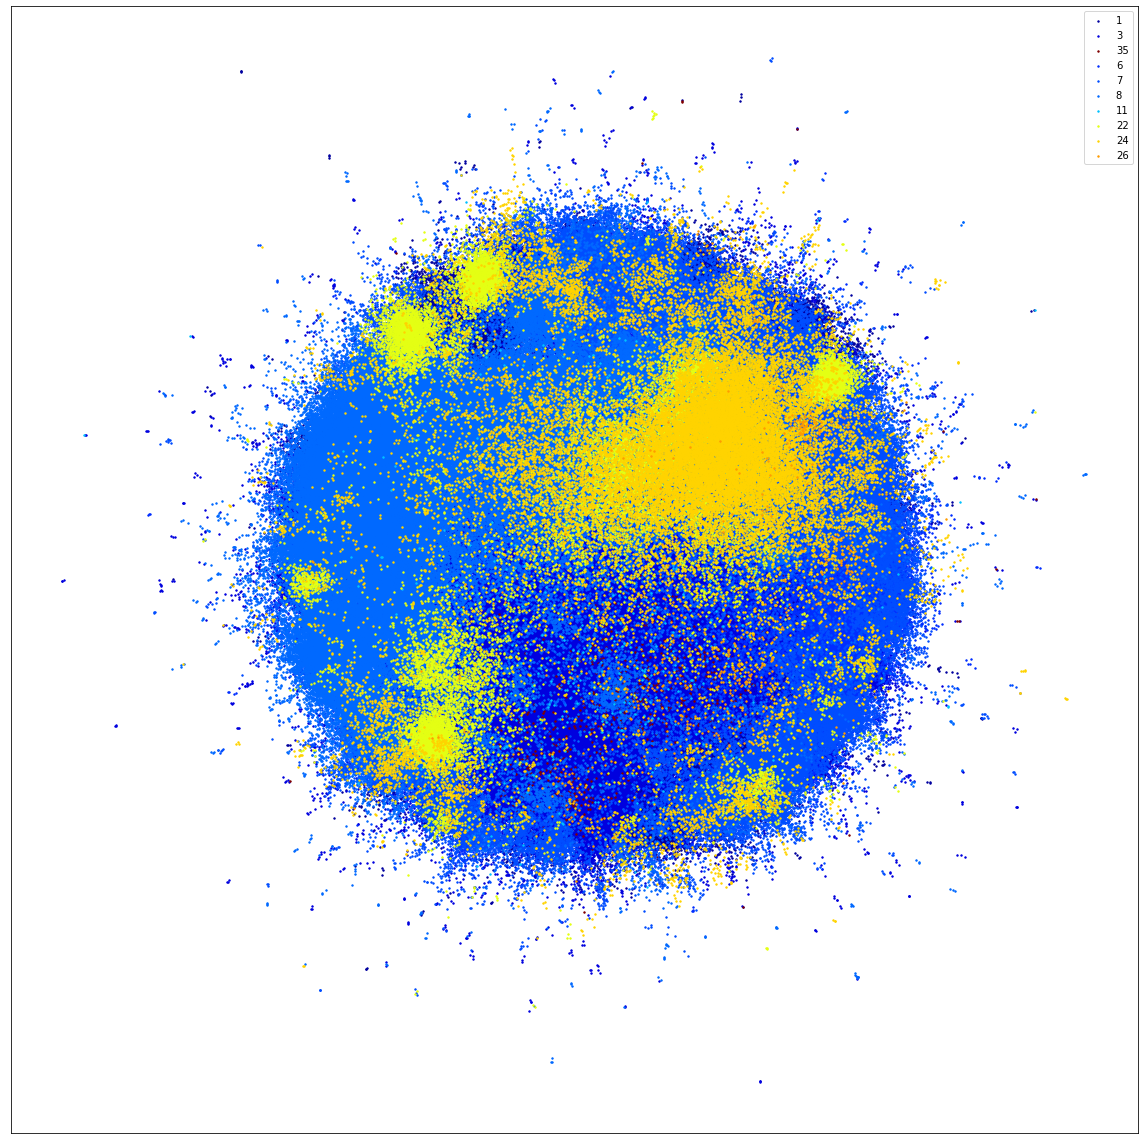

IVHD euclidean 3nn: 1992.0988957881927 [s]


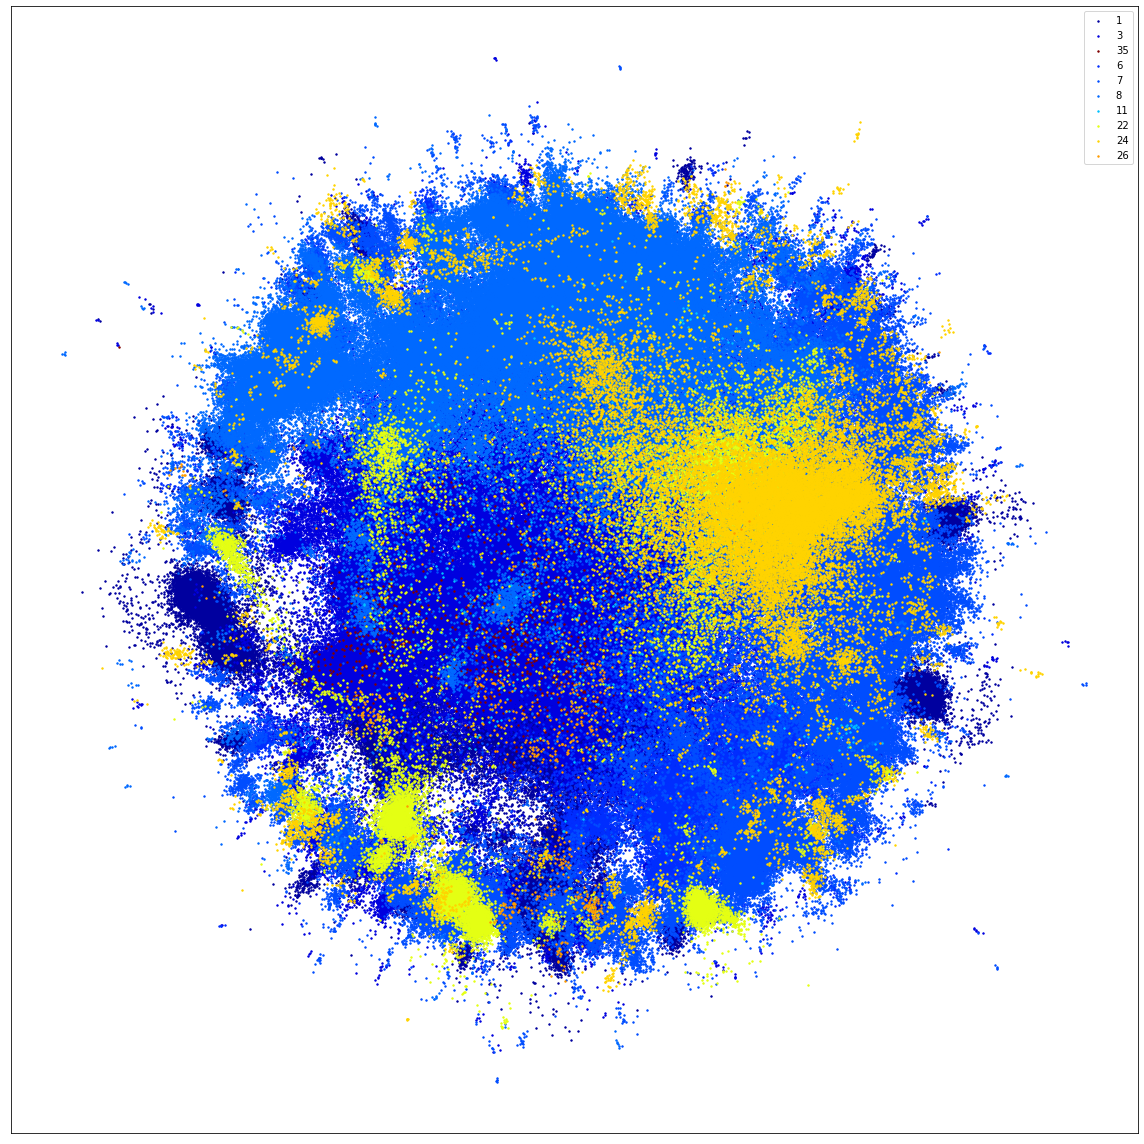

IVHD euclidean 5nn: 2648.1501829624176 [s]


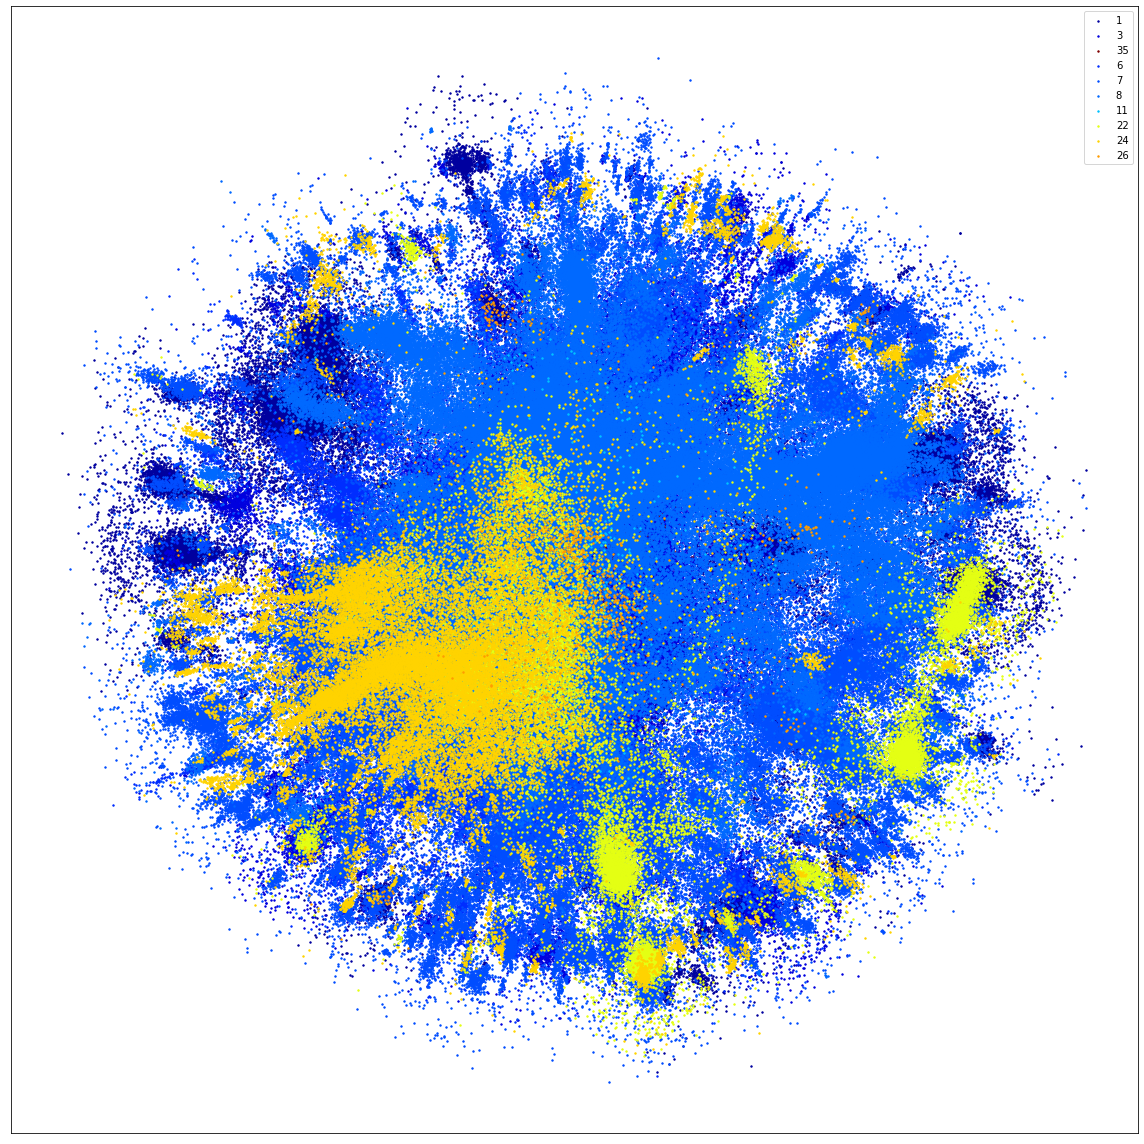

In [10]:
i = 0
for ivhd_result in ivhd_results:
    print("{}: {} [s]".format(ivhd_names[i], ivhd_timings[i]))
    plot_2d_scatter(ivhd_result[:,0], ivhd_result[:,1], labels)
    i += 1

### LargeVis

In [11]:
largevis_const_args = {
    'dir': "../viskit_offline",
    'dataset_csv': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv",
    'labels_csv': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_labels.csv",
    'output': "../data/reuters.txt",
    'iter': 1,
    'bd': 1, # binaryDistances
    'rns': 0, # reverseNeighborsSteps
    'rnc': 0, # reverseNeighborsCount
    'l1s': 0, # l1Steps
    'optimizer': "largevis"
}

largevis_args = [
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 3, 'rn': 1},
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 10, 'rn': 1},
    {'gp': "/Users/bartoszminch/Documents/Repositories/dataset_viskit/graphs/reuters_largest_components_euclidean.bin", 'nn': 30, 'rn': 1},
]

largevis_names = [
    "LargeVis 3nn",
    "LargeVis 10nn",
    "LargeVis 30nn",
]

def get_largevis_result(output_file) -> pd.DataFrame:
    df_ivhd = pd.read_csv(output_file, header=None)
    x_ivhd = df_ivhd.loc[:, '0':'1'].values
    return x_ivhd

import os

largevis_results = []
largevis_timings = []

i = 0
for args in largevis_args:
    gp_arg = args['gp']
    nn_arg = args['nn']
    rn_arg = args['rn']

    command = '{dir} "{data_csv}" "{labels_csv}" "{gp}" {output} {iter} {nn} {rn} {bd} {rns} {rnc} {l1s} "{optimizer}"'.format(
        dir = largevis_const_args['dir'],
        data_csv = largevis_const_args['dataset_csv'],
        labels_csv = largevis_const_args['labels_csv'],
        gp = gp_arg,
        output = largevis_const_args['output'],
        iter = largevis_const_args['iter'],
        nn = nn_arg,
        rn = rn_arg,
        bd = largevis_const_args['bd'],
        rns = largevis_const_args['rns'],
        rnc = largevis_const_args['rnc'],
        l1s = largevis_const_args['l1s'],
        optimizer = largevis_const_args['optimizer'],
    )

    largevis_start = time.time()
    os.system(command)
    largevis_end = time.time()
    largevis_timings.append(largevis_end-largevis_start)

    res = get_largevis_result(largevis_const_args['output'])
    np.savetxt("../embeddings/reuters/{}.txt".format(largevis_names[i].lower().replace(" ", "_")), res, delimiter=",", fmt='%.6e')
    largevis_results.append(res)
    i += 1

[Info] [CSV Parser] Loading dataset from file: /Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_data.csv
[Info] [CSV Parser] Loading labels from file: /Users/bartoszminch/Documents/Repositories/dataset_viskit/datasets/reuters_largest_components_labels.csv
[Info] [CSV Parser] Labels file passed.
[Info] [CSV Parser] Dataset size: 795645
[Info] [CSV Parser] Dataset dimensionality: 30
[Info] [CSV Parser] Number of classes in dataset: 10
[Info] [CSV Parser] Finished.
[Info] [Graph] Loading graph from cache...
[Info] [Graph] Using binary distances...
[Info] [Graph] Finished.
[Info] [kNN Generator] Determining random neighbors...
[Info] [kNN Generator] Finished.
[Info] [kNN Generator] Neighbors in graph: 3182580
[Info] init done
Fitting model	Alpha: 1.00067 Progress: -0.0669741
Fitting model	Alpha: 1.00134 Progress: -0.133948
Fitting model	Alpha: 1.00201 Progress: -0.200922
Fitting model	Alpha: 1.00268 Progress: -0.267896
Fitting model	Alpha: 1.003

KeyboardInterrupt: 

In [ ]:
i = 0
for largevis_result in largevis_results:
    print("{}: {} [s]".format(largevis_names[i], largevis_timings[i]))
    plot_2d_scatter(largevis_result[:,0], largevis_result[:,1], labels)
    i += 1

### Comparison of all methods

In [ ]:
figure, axis = plt.subplots(3, 6)
figure.set_size_inches(100,50)

methods_names = [
    ["t-SNE perplexity 40", "t-SNE perplexity 80", "t-SNE perplexity 120"],
    ["UMAP 15 neighbours", "UMAP 30 neighbours", "UMAP 50 neighbours"],
    ["TriMAP 10 inliers", "TriMAP 20 inliers", "TriMAP 40 inliers"],
    ["PacMAP 10 nn", "PacMAP 15 nn", "PacMAP 20 nn"],
    [largevis_names[0], largevis_names[1], largevis_names[2]],
    [ivhd_names[0], ivhd_names[1], ivhd_names[2]], # euclidean
    # [ivhd_names[3], ivhd_names[4], ivhd_names[5]], # cosine
]

methods_results = [
    [tsne_p40_transformed, tsne_p80_transformed, tsne_p120_transformed],
    [umap_nn15_transformed, umap_nn30_transformed, umap_nn50_transformed],
    [trimap_ni10_transformed, trimap_ni20_transformed, trimap_ni40_transformed],
    [pacmap_nn10_transformed, pacmap_nn15_transformed, pacmap_nn20_transformed],
    [largevis_results[0], largevis_results[1], largevis_results[2]],
    [ivhd_results[0], ivhd_results[1], ivhd_results[2]], # euclidean
    # [ivhd_results[3], ivhd_results[4], ivhd_results[5]], # cosine
]

labels_for_plot = labels.to_numpy().flatten()
unique = list(set(labels_for_plot))
colors = [plt.cm.jet(float(i) / max(unique)) for i in unique]

for j in range(6):
    for i in range(3):
        axis[i, j].set_title(methods_names[j][i], fontsize=50)

        X = methods_results[j][i][:, 0]
        Y = methods_results[j][i][:, 1]

        for k, u in enumerate(unique):
            xi = [X[j] for j in range(len(X)) if labels_for_plot[j] == u]
            yi = [Y[j] for j in range(len(X)) if labels_for_plot[j] == u]
            axis[i, j].scatter(xi, yi, color=colors[k], label=str(u), alpha=0.8, s=2)

plt.show()

### DR quality and KNN gain

In [ ]:
dataset_best_method_results = LocalMetric()

def metric_calculate(metric, embedding, method_names):
    for i in range(len(embedding)):
        metric.calculate_knn_gain_and_dr_quality(
            X_lds=embedding[i],
            X_hds=dataset,
            labels=labels.to_numpy(),
            method_name=method_names[i],
        )

embeddings_best = [tsne_p40_transformed, umap_nn15_transformed, trimap_ni10_transformed, pacmap_nn10_transformed, largevis_results[1], ivhd_results[0]]
method_names_best = ["t-SNE perplexity 40", "UMAP 15 neighbours", "TriMAP 10 inliers", "PacMAP 10nn", "LargeVis 10nn", "IVHD 2nn"]

metric_calculate(dataset_best_method_results, embeddings_best, method_names_best)

In [ ]:
dataset_best_method_results.visualize()

### Trustworthiness

In [ ]:
from sklearn.manifold import trustworthiness

def trustworthiness_calculate(embeddings, method_names):
    for j in range(len(embeddings)):
        for nn in [5, 15, 30, 50]:
            metric_value = trustworthiness(
                X=dataset[0:5000],
                X_embedded=embeddings[j][0:5000],
                n_neighbors=nn,
            )

            print("[{}] Trustworthiness (nn={}): {}".format(method_names[j], nn, metric_value))

trustworthiness_calculate(embeddings_best, method_names_best)

### Shepard matrix

In [ ]:
figure, axis = plt.subplots(1, 6)
figure.set_size_inches(60,10)

embeddings = [tsne_p40_transformed, umap_nn15_transformed, trimap_ni10_transformed, pacmap_nn10_transformed, largevis_results[1], ivhd_results[0]]
method_names = ["t-SNE perplexity 40", "UMAP 15 neighbours", "TriMAP 10 inliers", "PacMAP 10nn", "LargeVis 10nn", "IVHD 2nn"]

dists_hd = pdist(dataset[0:2500])

for j in range(6):
    axis[j].set_title("Shepard diagram for {}".format(method_names[j]), fontsize=20)

    dists_ld = pdist(embeddings[j][0:2500])

    idxs_shep = np.random.choice(dists_ld.shape[0], 5000, replace=False)
    shepard_plot = np.stack([dists_hd[idxs_shep], dists_ld[idxs_shep]], axis=-1).reshape(-1, 2)

    axis[j].set_xlabel("Distance in original space", fontsize=15)
    axis[j].set_ylabel("Distance in reduced dimensionality", fontsize=15)
    axis[j].scatter(shepard_plot[:, 0], shepard_plot[:, 1], alpha=0.2)
    axis[j].grid()

plt.show()
